# Stock Price Prediction using FFT

## Project Overview
This Jupyter notebook explores the use of Fast Fourier Transform (FFT) in predicting stock prices. The approach leverages historical stock price data and uses the Fourier Transform to analyze this data within the frequency domain and interpolate values using least squares approximation. This project compares the Discrete Fourier Transform (DFT) with the Discrete Fourier Cosine Transform (DCT) using two performance metrics. Note, that I will be using the phrase FFT and DFT interchangebly. DFT is the Discrete Fourier Transform and FFT is the python implementation of the Discrete Fourier Transform (in $O(n \log n)$ time). 

## Objectives
- Fetch historical stock price data.
- Apply FFT.
- Develop models to predict future stock prices.
- Evaluate and compare models using RMSE and MASE.

## Setup and Data Import

In this section, we import necessary libraries and fetch historical stock data using the `yfinance` API. The libraries include:
- `numpy` for numerical operations.
- `pandas` for numerical operations and to analyse dataframes. 
- `matplotlib.pyplot` for plotting graphs.
- `scipy` for performing the FFT and DCT.
- `yfinance` for downloading historical stock data.

In [3]:
import pandas as pd
import numpy as np
from scipy import fftpack
from scipy.fftpack import fft, dct
import matplotlib.pyplot as plt
import yfinance as yf

## Fourier Transform Modelling 

Here, we model and predict the stock prices using the Fast Fourier Transform and regression. The combination of least squares and FFT interpolation can offer a unique way to predict stock prices, which we are going to explore now. 

### What is the process and how do we use the Fourier Transform? 
1. Baseline Model: We start by fitting a polynomial least squares model to the training data. This provides a baseline model that captures the overall trend of the stock prices over time. In this case, we use a third-degree polynomial to avoid overfitting while capturing the general trend.

2. Residuals and Fourier Transform: Once the baseline model is fitted, we compute the residuals (the differences between the actual stock prices and the predicted values from the polynomial model). These residuals are then transformed into the frequency domain using the Discrete Fourier Transform (DFT) or the Discrete Cosine Transform (DCT). This conversion allows us to perform frequency-based extrapolation more effectively.

3. Manual Reconstruction and Interpolation: After transforming the residuals, we manually reconstruct the inverse Discrete Fourier Transform (IDFT) of the predicted residuals. During this process, we manually handle the extrapolation, ensuring that the predicted residuals can be converted back into the time domain. This step is necessary because standard IDFT may not account for the need to predict beyond the original data points, making manual intervention essential.

4. Reconstructing Predictions: The interpolated residuals are then added back to the polynomial fit, providing the final predicted stock prices. This combination of polynomial trend and Fourier-based residual adjustments offers a more refined prediction than simply polynomial prediction. Our aim is to see how much more sophisticated is this method.

5. Model Evaluation: Finally, we evaluate the performance of our model using the RMSE and MASE metrics on the test dataset, as it provides a more robust measure of accuracy for time series data.

## Defining Key Functions

This section defines a Model class that encapsulates the core functionality for both FFT and DCT-based stock price prediction models. Key functions include:

1. Initialization and data splitting into test and train sets
2. Polynomial fitting to capture overall trends
3. Residual calculation and transformation (FFT or DCT)
4. Prediction of future residuals using inverse transforms
5. Error calculation (RMSE and MASE)
6. Visualization functions for fitted polynomials, residuals, transforms, and predictions

These functions provide a structured approach to implementing and comparing FFT and DCT-based stock price forecasting methods.

In [4]:
class Model():
    def __init__(self, model_name : str, test_ratio : float = 0.2):
        self.model_name = model_name
        self.test_ratio = test_ratio
        self.CLOSE_COLUMN = 'Close'
        
        if self.model_name not in ['fft', 'dct']:
            raise ValueError('Only "fft" and "dct" models are supported')

        if self.test_ratio <= 0 or self.test_ratio >= 1:
            raise ValueError('Test ratio should be between 0 and 1')
        
    def get_train_size(self):
        return int(len(self.df) * (1 - self.test_ratio))
    
    def get_test_size(self):
        return len(self.df) - self.get_train_size()
    
    def split_train_test(self):
        self.train_df = self.df.iloc[:self.get_train_size()]
        self.test_df = self.df.iloc[self.get_train_size():]
    
    def fit(self, df : pd.DataFrame, n_degree: int):
        self.df = df
        self.split_train_test()

        self.poly_model = np.polyfit(np.arange(1, len(self.train_df) + 1), self.train_df[self.CLOSE_COLUMN], n_degree)
        
        self.residuals = self.train_df[self.CLOSE_COLUMN].values - np.polyval(self.poly_model, np.arange(1, len(self.train_df) + 1))
        
        if self.model_name == 'fft':
            self.fft_values = fft(self.residuals)
        elif self.model_name == 'dct':
            self.fft_values = dct(self.residuals, norm='ortho')
    
    def predict_and_compare(self):
        if self.model_name == 'fft':
            self.iff_residuals = self.predict_residuals_using_fft()
        elif self.model_name == 'dct':
            self.iff_residuals = self.predict_residuals_using_dct()
        elif self.model_name == 'cosine':
            self.iff_residuals = self.predict_residuals_using_cosine()
        self.predicted_values = np.polyval(self.poly_model, np.arange(self.get_train_size() + 1, len(self.df) + 1)) + self.iff_residuals
        self.print_rmse()
        self.print_mase()
            
    def predict_residuals_using_fft(self):
        a = np.real(self.fft_values)
        b = -np.imag(self.fft_values)
        
        predicted_residuals = np.zeros(self.get_test_size())

        omk = 2 * np.pi * np.arange(self.get_train_size()) / self.get_train_size()
        
        for i in range(self.get_test_size()):
            angle = omk * i
            predicted_residuals[i] = np.sum(a * np.cos(angle) + b * np.sin(angle))
            predicted_residuals[i] = - predicted_residuals[i] / self.get_train_size()
            
        return predicted_residuals
    

    def predict_residuals_using_dct(self):
        dct_coeffs = self.fft_values.copy()
        dct_coeffs[1:] *= np.sqrt(2)
        
        predicted_residuals = np.zeros(self.get_test_size())
        
        x_0 = dct_coeffs[0]
        for k in range(self.get_train_size() + 1, len(self.df)):
            y_k = x_0 / np.sqrt(self.get_train_size())
            for n in range(1, self.get_train_size()):
                angle = (np.pi * (2 * k + 1) * n) / (2 * self.get_train_size())
                y_k += np.sqrt(2/self.get_train_size()) * dct_coeffs[n] * np.cos(angle)
            predicted_residuals[k - self.get_train_size() - 1] = y_k
        
        return predicted_residuals
        
        
  
    def predict_residuals_using_cosine(self):
        return np.zeros(self.get_test_size())
    
    def print_rmse(self):
        print('RMSE:', np.sqrt(np.mean((self.test_df[self.CLOSE_COLUMN] - self.predicted_values)**2)))
    
    def print_mase(self):
        mae = np.mean(np.abs(self.test_df[self.CLOSE_COLUMN] - self.predicted_values))
        naive_forecast = self.test_df[self.CLOSE_COLUMN][:-1].values
        naive_forecast_mae = np.mean(np.abs(self.test_df[self.CLOSE_COLUMN][1:].values - naive_forecast))
        print('MASE:', mae / naive_forecast_mae)
        
    def plot_poly_fit(self):
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(1, len(self.train_df) + 1), self.train_df[self.CLOSE_COLUMN], label='Train Data')
        plt.plot(np.arange(len(self.train_df) + 1, len(self.df) + 1), self.test_df[self.CLOSE_COLUMN], label='Test Data')
        train_poly_values = np.polyval(self.poly_model, np.arange(1, len(self.train_df) + 1))
        plt.plot(np.arange(1, len(self.train_df) + 1), train_poly_values, label='Polynomial Fit on Train Data')
        test_poly_values = np.polyval(self.poly_model, np.arange(len(self.train_df) + 1, len(self.df) + 1))
        plt.plot(np.arange(len(self.train_df) + 1, len(self.df) + 1), test_poly_values, label='Predicted Polynomial Fit')
        plt.xlabel('Time (days)')
        plt.ylabel('Stock Close Price')
        plt.title('Polynomial Fit and Actual Data')
        plt.legend()
        plt.show()
            
    def plot_residuals(self):
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(1, len(self.train_df) + 1), self.residuals, label='Train Residuals')
        plt.plot(np.arange(len(self.train_df) + 1, len(self.df) + 1), self.iff_residuals, label='Predicted Residuals')
        plt.xlabel('Time (days)')
        plt.ylabel('Residuals')
        plt.title('Difference between Actual and Polynomial Fit')
        plt.legend()
        plt.show()
        
    def plot_residuals_fft(self):
        plt.figure(figsize=(10, 5))
        plt.plot(np.abs(self.fft_values))
        plt.xlabel('frequency (rad/s)')
        plt.ylabel('Magnitude')
        plt.title(f'{self.model_name} of the difference')
        plt.show()
        
    def plot_predicted_values(self):
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(1, len(self.df) + 1), self.df[self.CLOSE_COLUMN], label='Actual Price')
        plt.plot(np.arange(len(self.train_df) + 1, len(self.df) + 1), self.predicted_values, label='Predicted Price')
        plt.xlabel('Time (days)')
        plt.ylabel('Stock Close Price')
        plt.title(f'Stock price: Actual vs. Theoretical over extended days using {self.model_name} for {self.get_test_size()} days')
        plt.legend()
        plt.show()  

## Goldman Sachs

### Fetching stockprice data 

We fetch data for Goldman Sachs from the last 13 years

In [5]:
goldman_sachs = yf.download("GS", start="2011-01-01", end="2024-05-01")

[*********************100%%**********************]  1 of 1 completed


### Model implentation

We implement our functions below

RMSE: 16.06300302031831
MASE: 3.338060517505133


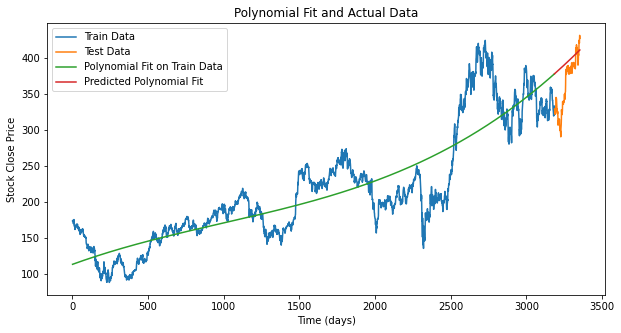

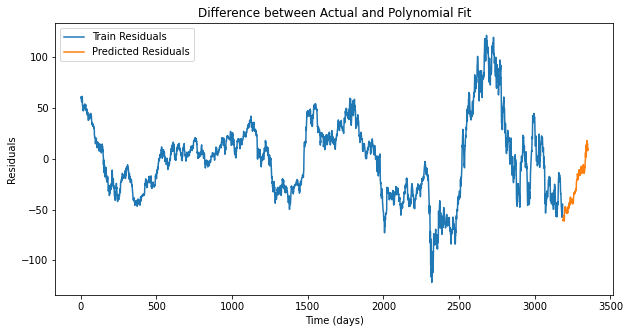

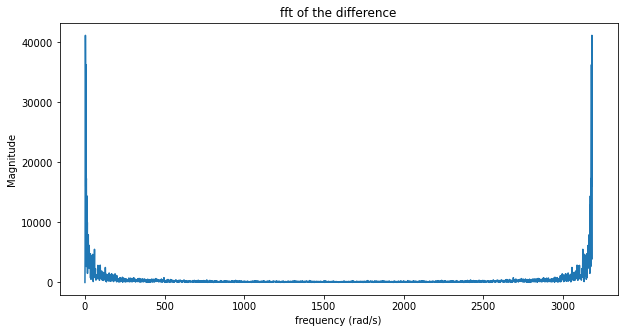

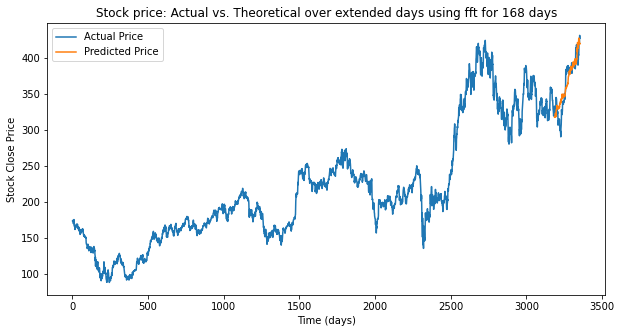

In [6]:
model = Model(model_name='fft', test_ratio=0.05)
model.fit(goldman_sachs, 3)
model.predict_and_compare()
model.plot_poly_fit()
model.plot_residuals()
model.plot_residuals_fft()
model.plot_predicted_values()    

RMSE: 27.05023438650995
MASE: 6.241214127578152


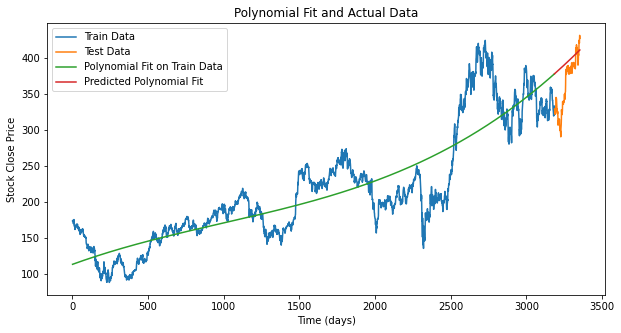

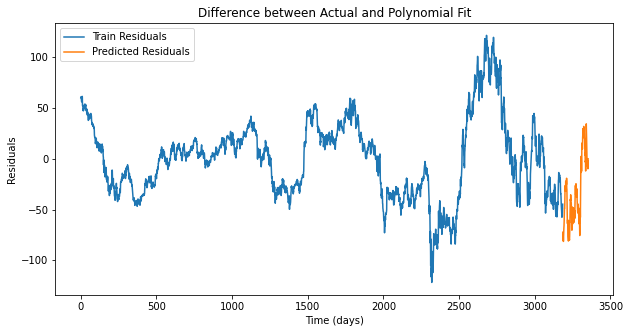

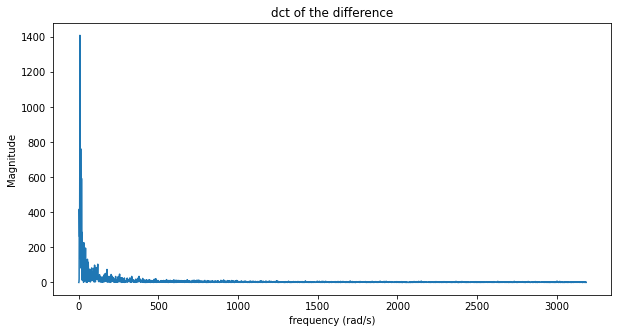

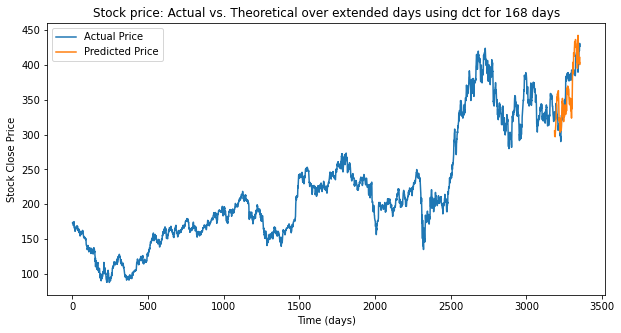

In [7]:
model = Model(model_name='dct', test_ratio=0.05)
model.fit(goldman_sachs, 3)
model.predict_and_compare()
model.plot_poly_fit()
model.plot_residuals()
model.plot_residuals_fft()
model.plot_predicted_values()    

## Apple

### Fetching stockprice data 

We fetch data for Apple from the last 13 years

In [8]:
apple = yf.download("AAPL", start="2011-01-01", end="2024-05-01")

[*********************100%%**********************]  1 of 1 completed


### Model implentation

We implement our functions below

RMSE: 38.40991514077157
MASE: 20.904343959182015


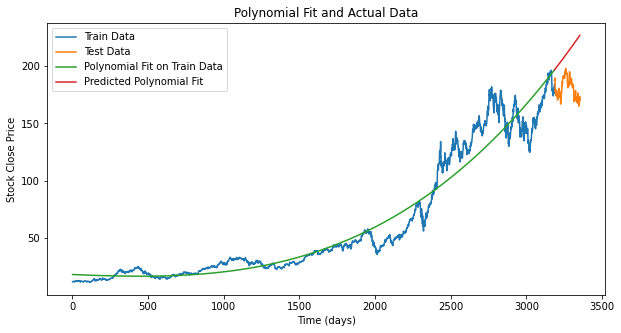

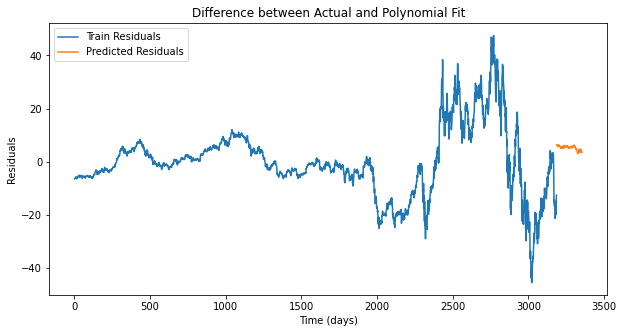

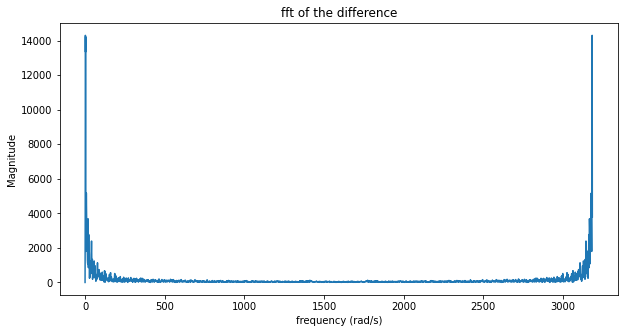

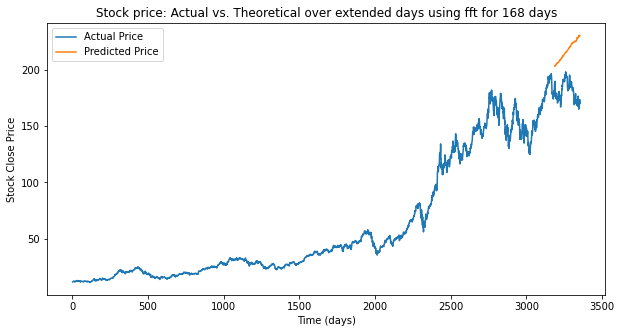

In [9]:
model = Model(model_name='fft', test_ratio=0.05)
model.fit(apple, 3)
model.predict_and_compare()
model.plot_poly_fit()
model.plot_residuals()
model.plot_residuals_fft()
model.plot_predicted_values()    

RMSE: 15.226298883718224
MASE: 6.199761728836119


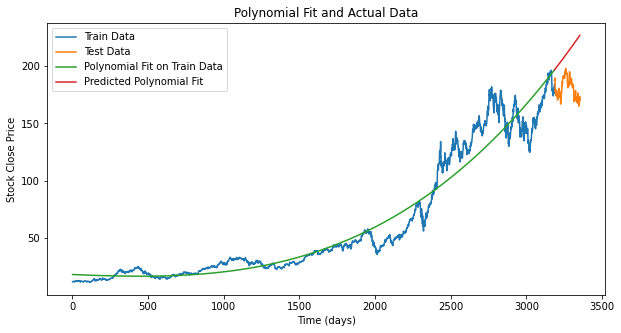

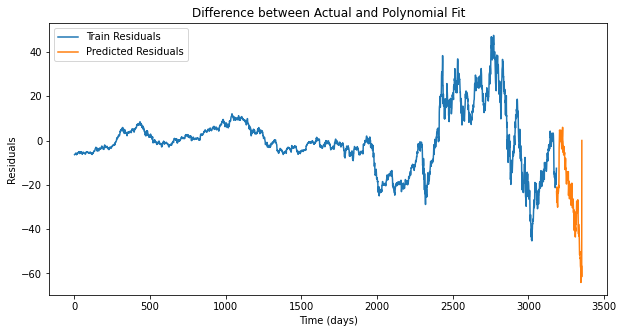

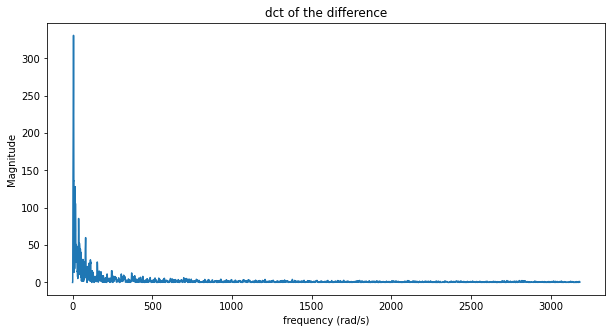

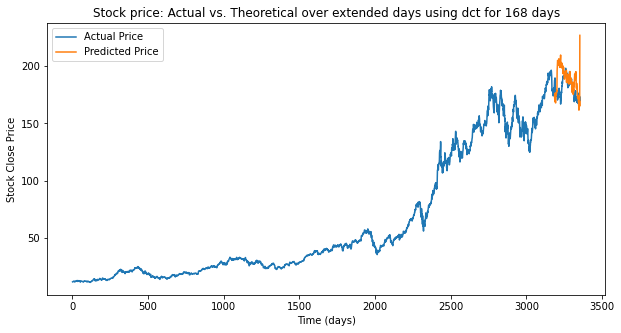

In [10]:
model = Model(model_name='dct', test_ratio=0.05)
model.fit(apple, 3)
model.predict_and_compare()
model.plot_poly_fit()
model.plot_residuals()
model.plot_residuals_fft()
model.plot_predicted_values()    

## Amazon

### Fetching stockprice data 

We fetch data for Amazon from the last 13 years

In [11]:
amazon = yf.download("AMZN", start="2011-01-01", end="2024-05-01")

[*********************100%%**********************]  1 of 1 completed


### Model implentation

We implement our functions below

RMSE: 36.030929954125476
MASE: 14.376806415227028


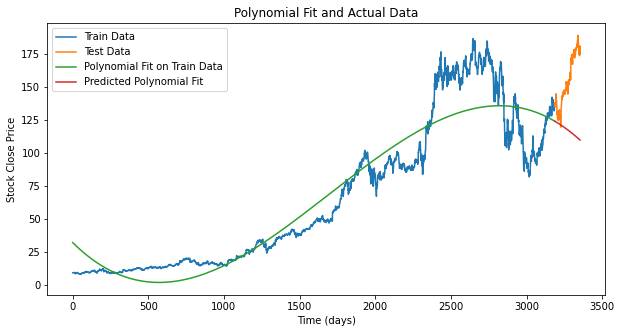

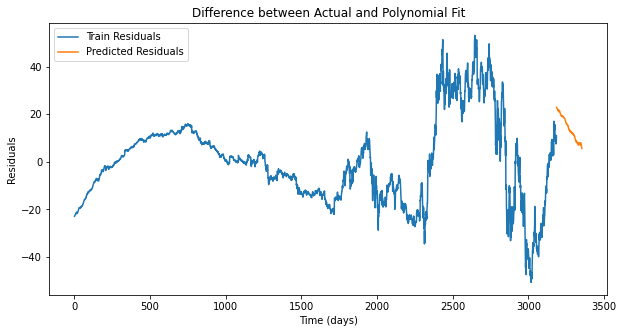

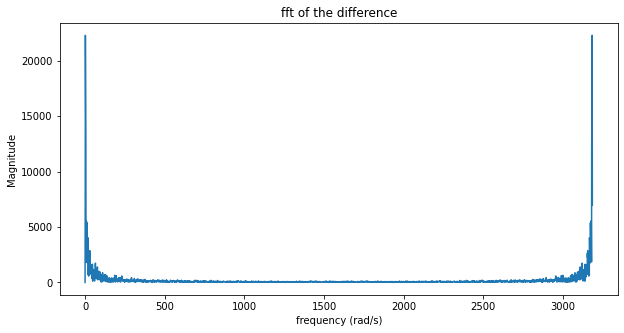

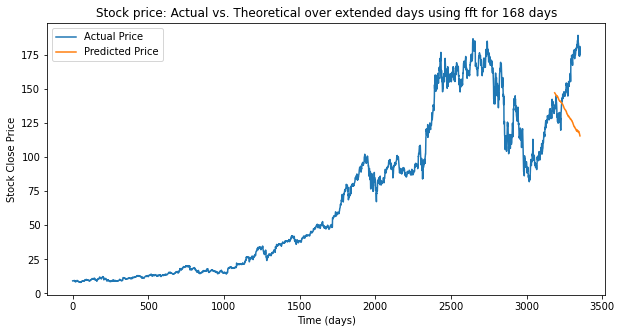

In [12]:
model = Model(model_name='fft', test_ratio=0.05)
model.fit(amazon, 3)
model.predict_and_compare()
model.plot_poly_fit()
model.plot_residuals()
model.plot_residuals_fft()
model.plot_predicted_values()    

RMSE: 77.70711479710046
MASE: 30.991562560968116


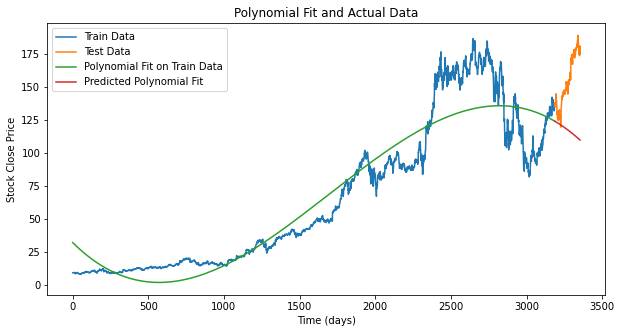

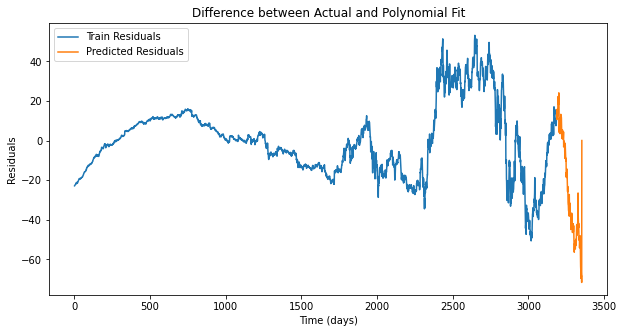

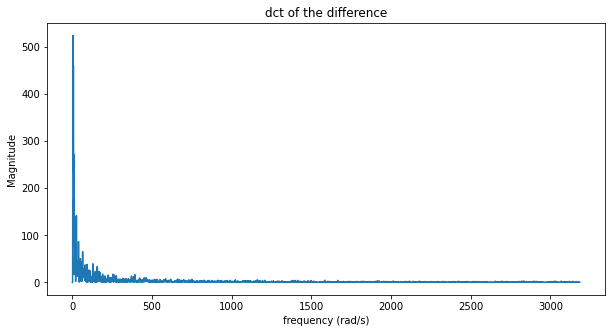

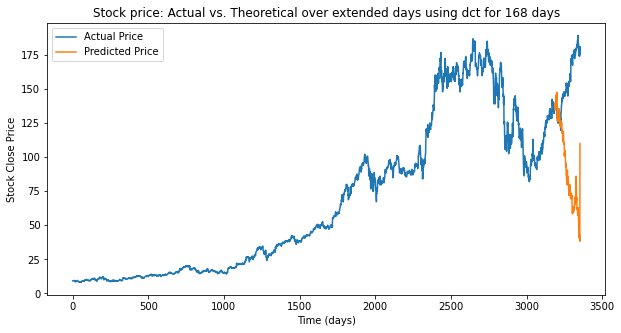

In [13]:
model = Model(model_name='dct', test_ratio=0.05)
model.fit(amazon, 3)
model.predict_and_compare()
model.plot_poly_fit()
model.plot_residuals()
model.plot_residuals_fft()
model.plot_predicted_values()    

## Summary of Findings and Conclusion

The resulting RMSE of 16.1 and MASE of 3.3 for Goldman Sachs DFT prediction indicates that the prediction was relatively accurate, particularly considering the simplicity of the approach, which involved basic regression. This level of accuracy is attributed to the power of the Fourier Transform, which simplifies analysis by converting the time series data into the frequency domain. Additionally, the computational complexity of the Fast Fourier Transform (FFT) is $O(n \log n)$, making it a highly efficient method for handling complex calculations. 

However, we can also see the over-reliance on having a good polynomial fit given by the larger RMSE and MASE errors for the Apple and Amazon stocks, that didnt conform as well to a polynomial regresison. 

Nevertheless, the tiny fluctations in price seem to be well captured by both the Fourier Transform and Fourier Cosine Transforms. Furthermore, both had relatively similar errors, with the DCT significantly outperforming the DFT for predicting Apple prices while the DFT outpeformed the DCT while predicting the prices for Goldman Sachs. Both metods showed massive errors in predicting Amazon prices due to the bad polynomial fit. 

Laslty, the fact that the DCT and DFT have similar results is indicative of the fact that we have a purely real signal and the sine components might not be contributing much. To further explore, we can look at the Discrete Sin transform of the stock prices as well.

In general, Fourier Transforms can be useful in looking at fluctuations if there is some peridocity in the fluctuations (the noise) and in conjunction with more complex analysis methods (than polynomial regression). This was nopt the case for these stocks hence the power of the Fourier Transform was limited. 

A scope for further research could be to look into Wavelet Transforms instead of Fourier Transforms as they are better at handling data with less periodicty as well as non-stationary time series data. 

# Conclusions 

1. The results very heavily dependent on how well the stock prices fit the polynomial
2. In general, the DCT is more efficient then DFT for stock prices
3. Fourier Transforms can be useful in looking at fluctuations if there is some peridocity in the data (especially the noise) and in conjunction with more complex analysis methods (than polynomial regression)
5. A scope for further research could be to look into Wavelet Transforms instead of Fourier Transforms as they are better at handling data with less periodicty as well as non-stationary time series data.  